In [1]:
import pyspark
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract, udf
from pyspark.sql import functions as F
spark = SparkSession.builder.appName('TD1').getOrCreate()

In [2]:
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} \+\d{4})]'
# timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]
method_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
# method = [re.search(method_pattern, item).group(1) for item in sample_logs]

In [3]:
month_map = {
        'Jan' : 1, 'Feb' : 2, 'Mar' : 3, 'Apr': 4, 'May' : 5, 'Jun' : 6, 'Jul': 7, 'Aug': 8, 'Sep' : 9, 'Oct': 10, 'Nov' : 11, 'Dec' : 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )
udf_parse_time = udf(parse_clf_time)

In [4]:
base_df = spark.read.option("header", "false") \
    .option("delimiter", "\t") \
    .option("inferSchema", "true") \
    .csv("/usr/data/sample_access_log") \
    .withColumnRenamed("_c0", "col")
sample_logs = [s['col'] for s in base_df.take(10)]
sample_logs[1]

'218.234.160.0 - - [01/Oct/2013:23:59:59 +0900] "GET /pub/Linux/linuxmint/packages/dists/olivia/upstream/i18n/Translation-ko.xz HTTP/1.1" 404 564 "-" "Debian APT-HTTP/1.3 (0.9.7.7ubuntu4)" ftp.jaist.ac.jp'

In [5]:
logs_df = base_df.select(
    regexp_extract('col', ts_pattern, 1).alias('timestamp'),
    regexp_extract('col', method_pattern, 1).alias('method'),
)
# transform timestamp field
logs_df = logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')


# voir page 61
logs_df.limit(10).show()
hours_df = logs_df.select('method', F.hour('time').alias('hour'))
hours_df.limit(10).show()

+------+-------------------+
|method|               time|
+------+-------------------+
|   GET|2013-10-01 23:59:58|
|   GET|2013-10-01 23:59:59|
|   GET|2013-10-01 23:59:59|
|   GET|2013-10-02 00:00:00|
|   GET|2013-10-02 00:00:00|
|   GET|2013-10-02 00:00:00|
|   GET|2013-10-02 00:00:00|
|   GET|2013-10-01 23:59:58|
|   GET|2013-10-02 00:00:00|
|   GET|2013-10-02 00:00:00|
+------+-------------------+

+------+----+
|method|hour|
+------+----+
|   GET|  23|
|   GET|  23|
|   GET|  23|
|   GET|   0|
|   GET|   0|
|   GET|   0|
|   GET|   0|
|   GET|  23|
|   GET|   0|
|   GET|   0|
+------+----+



In [5]:
grouped_hours_df = hours_df.groupBy('hour').count().sort('hour')
hours = [el['hour'] for el in grouped_hours_df.take(24)]
count = [el['count']/1000 for el in grouped_hours_df.take(24)]
hours
count

NameError: name 'hours_df' is not defined

NameError: name 'hours' is not defined

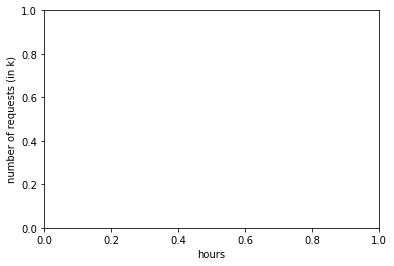

In [4]:
from matplotlib import pyplot as plt

plt.xlabel('hours')
plt.ylabel('number of requests (in k)')
plt.bar(hours, count)